<a href="https://colab.research.google.com/github/chloeahughes/Homelessness-in-California/blob/main/3_Model_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Developing Machine Learning Models**

Our objective is to build and evaluate different machine learning models to predict homelessness rates based on various socioeconomic factors, including housing costs, political affiliations, race demographics, and economic indicators.



### Overview
Linear Regression: Establishes a baseline by assuming a linear relationship between homelessness and predictor variables.

Multiple Linear Regression: Expands the model by including multiple predictors to capture more complex interactions.

K-Nearest Neighbors (KNN): Uses distance-based similarity to predict homelessness rates.

Random Forest: Utilizes ensemble learning to determine feature importance and improve accuracy.

XGBoost: A powerful gradient boosting model applied for final predictions and feature importance analysis.


### Evaluation
We train and test each model using stratified sampling to prevent biases in our predictions.

**Performance Metrics**:

R-squared (R²): Measures how well the model explains variability in homelessness rates.

Mean Absolute Error (MAE) & Root Mean Squared Error (RMSE): Evaluate prediction accuracy.

Feature Importance Analysis: Identifies the most influential factors affecting homelessness.

import libraries

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

Import data

In [ ]:
df_filtered = pd.read_csv('/content/final_df (1).csv')

In [ ]:
df_filtered.columns

Index(['Unnamed: 0', 'county', 'total_population_2019',
       'Count of Sheltered Homeless', 'Count of Unsheltered Homeless',
       'Count of Total Homeless', 'Funding Amount', 'Value (Percent)',
       'Total Registered', 'Democratic', 'Republican', 'American Independent',
       'Libertarian', 'Other', '2019-01-31_x', '2019-02-28_x', '2019-03-31_x',
       '2019-04-30_x', '2019-05-31_x', '2019-06-30_x', '2019-07-31_x',
       '2019-08-31_x', '2019-09-30_x', '2019-10-31_x', '2019-11-30_x',
       '2019-12-31_x', '2019-01-31_y', '2019-02-28_y', '2019-03-31_y',
       '2019-04-30_y', '2019-05-31_y', '2019-06-30_y', '2019-07-31_y',
       '2019-08-31_y', '2019-09-30_y', '2019-10-31_y', '2019-11-30_y',
       '2019-12-31_y', '% homeless', 'avg_housing_index_2019_zhvi',
       'avg_housing_index_2019_zori'],
      dtype='object')

In [ ]:
df_race = pd.read_csv('/content/race_population_rates (1).csv')

In [ ]:
df_race.rename(columns={"County": "county"}, inplace=True)

df_race["county"] = (
    df_race["county"]
    .str.replace(r"\s+county\s*$", "", case=False, regex=True)  # remove trailing "County"
    .str.strip()                                                # strip whitespace
    .str.lower()                                                # convert to lowercase
)


In [ ]:
df = pd.merge(df_filtered, df_race, on="county", how="inner")
df.columns

Index(['Unnamed: 0', 'county', 'total_population_2019',
       'Count of Sheltered Homeless', 'Count of Unsheltered Homeless',
       'Count of Total Homeless', 'Funding Amount', 'Value (Percent)',
       'Total Registered', 'Democratic', 'Republican', 'American Independent',
       'Libertarian', 'Other', '2019-01-31_x', '2019-02-28_x', '2019-03-31_x',
       '2019-04-30_x', '2019-05-31_x', '2019-06-30_x', '2019-07-31_x',
       '2019-08-31_x', '2019-09-30_x', '2019-10-31_x', '2019-11-30_x',
       '2019-12-31_x', '2019-01-31_y', '2019-02-28_y', '2019-03-31_y',
       '2019-04-30_y', '2019-05-31_y', '2019-06-30_y', '2019-07-31_y',
       '2019-08-31_y', '2019-09-30_y', '2019-10-31_y', '2019-11-30_y',
       '2019-12-31_y', '% homeless', 'avg_housing_index_2019_zhvi',
       'avg_housing_index_2019_zori', 'FIPS', 'Value (Percent)_White',
       'People (White)_White', 'Rank within US (of 3143 counties)_White',
       'Value (Percent)_Black or African American',
       'People (Black)_B

In [ ]:
# Calculate percentage for Democratic and Republican

df["Democratic"] = pd.to_numeric(df["Democratic"], errors="coerce")
df["Republican"] = pd.to_numeric(df["Republican"], errors="coerce")

df["Total Registered"] = df["Democratic"] + df["Republican"]
# Using fillna(0) to handle any division by zero (if total_votes is 0)
df["% democrat"] = (df["Democratic"] / df["Total Registered"]).fillna(0) * 100
df["% republican"] = (df["Republican"] / df["Total Registered"]).fillna(0) * 100

df.drop("Total Registered", axis=1, inplace=True)


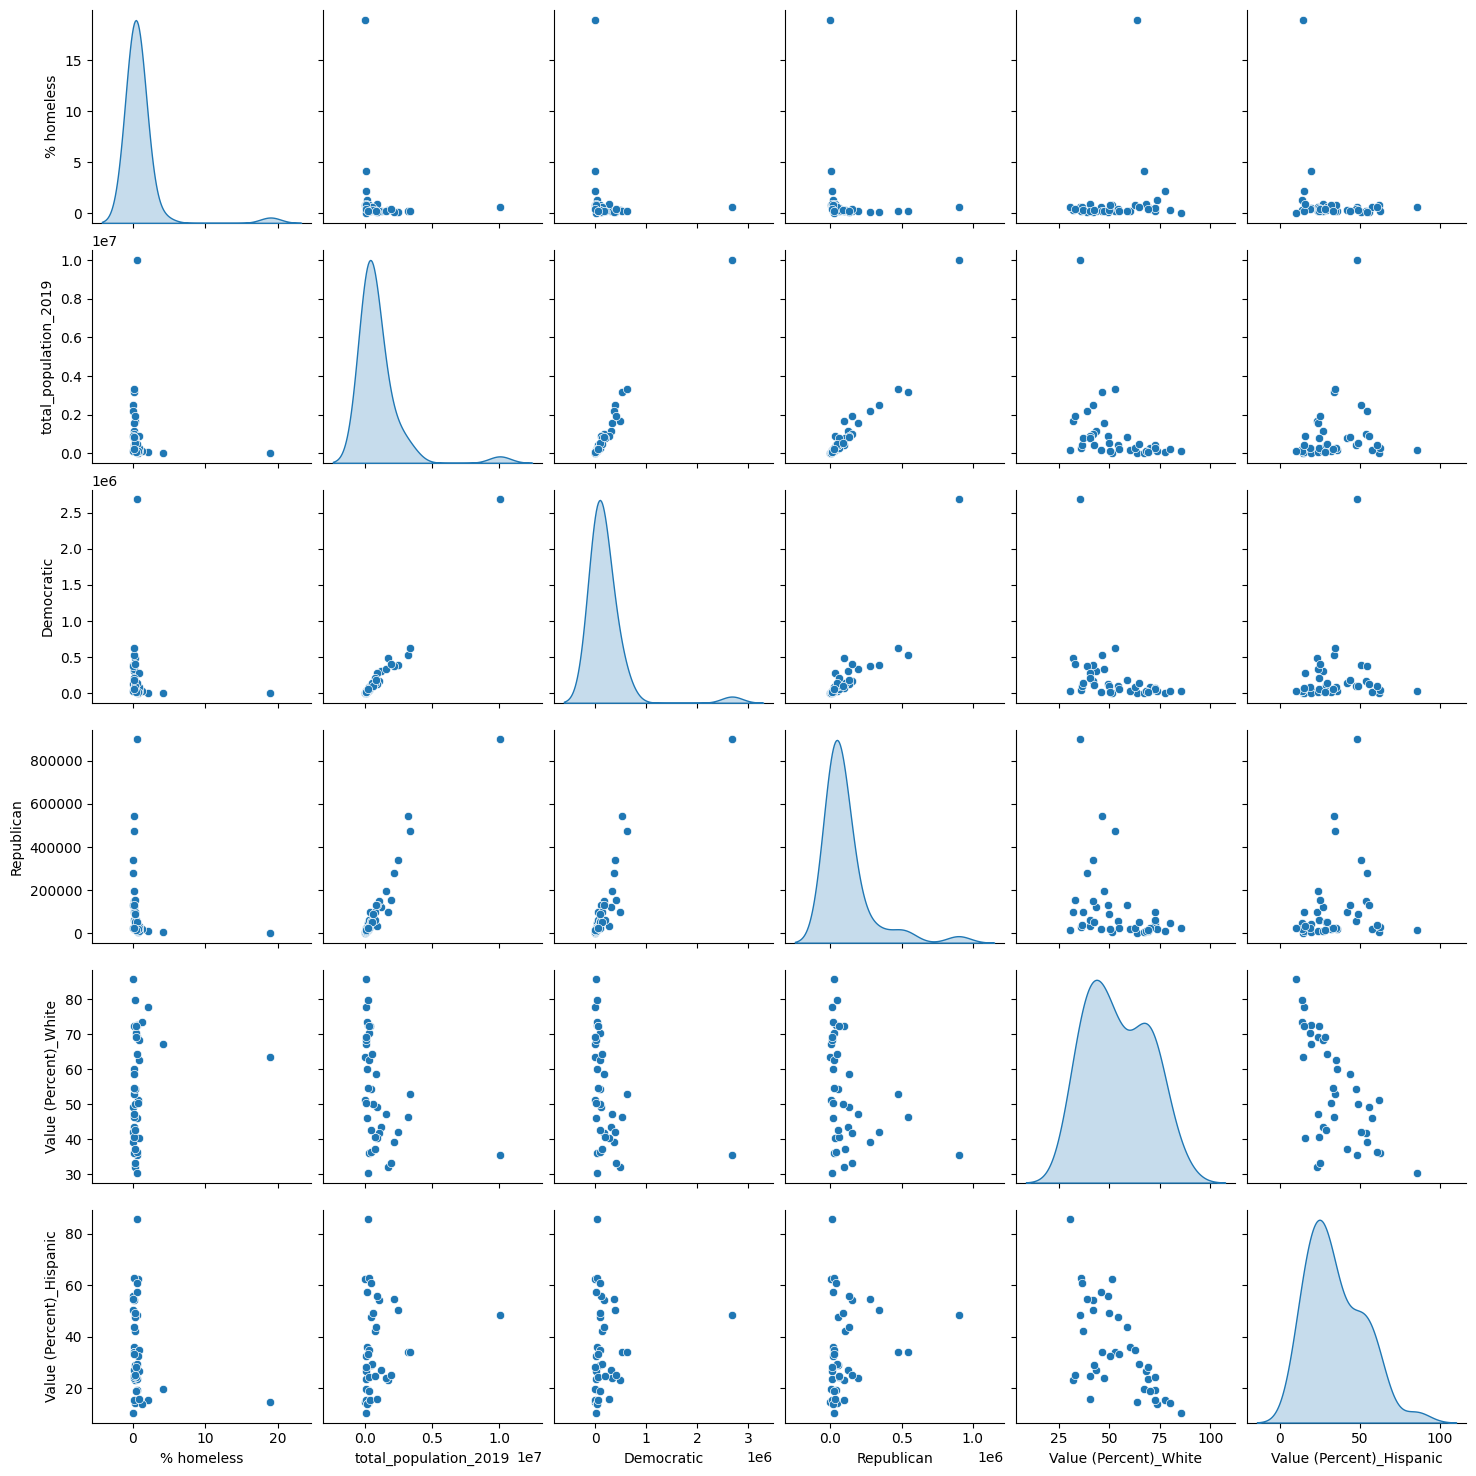

In [ ]:
cols = [
    "% homeless",
    "total_population_2019",
    "Democratic",
    "Republican",
    "Value (Percent)_White",
    "Value (Percent)_Hispanic"
]

sns.pairplot(df[cols], diag_kind="kde")  # or diag_kind="hist"
plt.show()


# **Linear regression**

we chose to start off with this because we are expecting a linear relationship between:

- homeless and total population voter registration in California
- homeless and total population race in California
- homeless and housing index



variables: variables that we think would have a linear relationship

### Democratic vs. Republican

In [ ]:
X = df[['Democratic']]
y = df['% homeless']

# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the linear regression model
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -15.409864038622299
Coefficients: [('Democratic', -7.756201420844396e-07)]


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define X and y using only the '% Republican' column and '% homeless' as target.
X = df[['Republican']]
y = df['% homeless']

# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the linear regression model
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -14.664254513115957
Coefficients: [('Republican', -2.6274328285915497e-06)]


Republican has the lowest r^2.

### high school dropout rates

In [ ]:
X = df[['Value (Percent)']]
y = df['% homeless']

# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the linear regression model
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -19.163382325849586
Coefficients: [('Value (Percent)', -0.13099631160399358)]


### Race

In [ ]:
X = df[['Value (Percent)_White']]
y = df['% homeless']
# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -15.615553830138378
Coefficients: [('Value (Percent)_White', 0.034533732613814316)]


In [ ]:
X = df[['Value (Percent)_Hispanic']]
y = df['% homeless']
# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -13.355325938232317
Coefficients: [('Value (Percent)_Hispanic', -0.043770644719243385)]


In [ ]:
X = df[['Value (Percent)_Black or African American']]
y = df['% homeless']
# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -19.18913077718811
Coefficients: [('Value (Percent)_Black or African American', -0.25754351578715123)]


In [ ]:
X = df[['Value (Percent)_Asian, Native Hawaiian or Pacific Islander']]
y = df['% homeless']
# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -20.58178142995349
Coefficients: [('Value (Percent)_Asian, Native Hawaiian or Pacific Islander', -0.0681541859010529)]


In [ ]:
X = df[['Value (Percent)_Foreign Born']]
y = df['% homeless']
# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -24.52088330671283
Coefficients: [('Value (Percent)_Foreign Born', -0.11820517019419548)]


In [ ]:
X = df[['Value (Percent)_American Indian or Alaska Native']]
y = df['% homeless']
# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -6.7819617520497175
Coefficients: [('Value (Percent)_American Indian or Alaska Native', -0.5162802469549826)]


American Indian/ Alaska Native has the lowest r^2.

### Housing

In [ ]:
housing_months_zhvi = [
    "2019-01-31_x", "2019-02-28_x", "2019-03-31_x",
    "2019-04-30_x", "2019-05-31_x", "2019-06-30_x",
    "2019-07-31_x", "2019-08-31_x", "2019-09-30_x",
    "2019-10-31_x", "2019-11-30_x", "2019-12-31_x"
]
housing_months_zori = [
    "2019-01-31_y", "2019-02-28_y", "2019-03-31_y",
    "2019-04-30_y", "2019-05-31_y", "2019-06-30_y",
    "2019-07-31_y", "2019-08-31_y", "2019-09-30_y",
    "2019-10-31_y", "2019-11-30_y", "2019-12-31_y"
]
df.dropna(subset=[
    "2019-01-31_x", "2019-02-28_x", "2019-03-31_x",
    "2019-04-30_x", "2019-05-31_x", "2019-06-30_x",
    "2019-07-31_x", "2019-08-31_x", "2019-09-30_x",
    "2019-10-31_x", "2019-11-30_x", "2019-12-31_x"
], inplace=True)
df.dropna(subset=[
    "2019-01-31_y", "2019-02-28_y", "2019-03-31_y",
    "2019-04-30_y", "2019-05-31_y", "2019-06-30_y",
    "2019-07-31_y", "2019-08-31_y", "2019-09-30_y",
    "2019-10-31_y", "2019-11-30_y", "2019-12-31_y"
], inplace=True)


In [ ]:
X = df[['avg_housing_index_2019_zhvi']]
y = df['% homeless']

# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the linear regression model
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -119.09322676918323
Coefficients: [('avg_housing_index_2019_zhvi', 1.004384521502091e-06)]


In [ ]:
X = df[['avg_housing_index_2019_zori']]
y = df['% homeless']

# Convert columns with potential comma-separated numbers to numeric
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = X[col].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        # Handle columns that cannot be converted, e.g., strings or dates
        pass

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the linear regression model
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear.predict(X_test)

# Calculate and print R-squared
r2 = linear.score(X_test, y_test)
print("R-squared:", r2)

# Print the coefficients for the predictor(s)
coefficients = list(zip(X.columns, linear.coef_))
print("Coefficients:", coefficients)


R-squared: -241.4974392111175
Coefficients: [('avg_housing_index_2019_zori', 0.00041955087487680526)]


In [ ]:

# Get predictions and calculate residuals on the training set
y_train_pred = linear.predict(X_train)
residuals = y_train - y_train_pred

# Residuals vs Fitted Values Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# Residuals vs Individual Predictors
for col in X_train.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_train[col], y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(col)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs {col}")
    plt.show()


Wow. Housing has an extremely high r^2, indicating the sum of squared errors is significantly larger than the total sum of errors.

## Best Combination of Features?

In [ ]:
import pandas as pd
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Example: your DataFrame `df` is already loaded
# Define the target variable and the full set of candidate features
y = df["% homeless"]
candidate_features = [
    "total_population_2019",
    "% democrat",
    "avg_housing_index_2019_zhvi",
    "avg_housing_index_2019_zori",
    "% republican",
    "Value (Percent)",
    "Value (Percent)_White",
    "Value (Percent)_Black or African American",
    "Value (Percent)_Hispanic",
    "Value (Percent)_Asian, Native Hawaiian or Pacific Islander",
    "Value (Percent)_Foreign Born",
    "Value (Percent)_American Indian or Alaska Native"
]
best_score = -np.inf   # Initialize with very low score
best_subset = None

# Loop over all possible subset sizes (1 to all features)
for r in range(1, len(candidate_features) + 1):
    # Generate all combinations of features of size r
    for subset in itertools.combinations(candidate_features, r):
        # Subset the DataFrame to these features
        X_subset = df[list(subset)]

        # Create a linear regression model
        model = LinearRegression()

        # Evaluate via cross-validation (5-fold by default)
        scores = cross_val_score(model, X_subset, y, scoring='r2', cv=5)
        mean_score = np.mean(scores)

        # Track the best subset so far
        if mean_score > best_score:
            best_score = mean_score
            best_subset = subset

print("Best subset of features:", best_subset)
print("Best cross-validated R2:", best_score)


Best subset of features: ('% democrat', 'avg_housing_index_2019_zhvi', 'avg_housing_index_2019_zori', '% republican', 'Value (Percent)_Black or African American', 'Value (Percent)_Foreign Born', 'Value (Percent)_American Indian or Alaska Native')
Best cross-validated R2: -0.014865970584127619


It seems is the Best subset of features: ('% democrat', 'avg_housing_index_2019_zhvi', 'avg_housing_index_2019_zori', '% republican', 'Value (Percent)_Black or African American', 'Value (Percent)_Foreign Born', 'Value (Percent)_American Indian or Alaska Native') with a low cross-val r^2 score of -0.014865970584127619

### Adding Regularization

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

Best alpha: 0.01
R-squared: -12.891043241938274


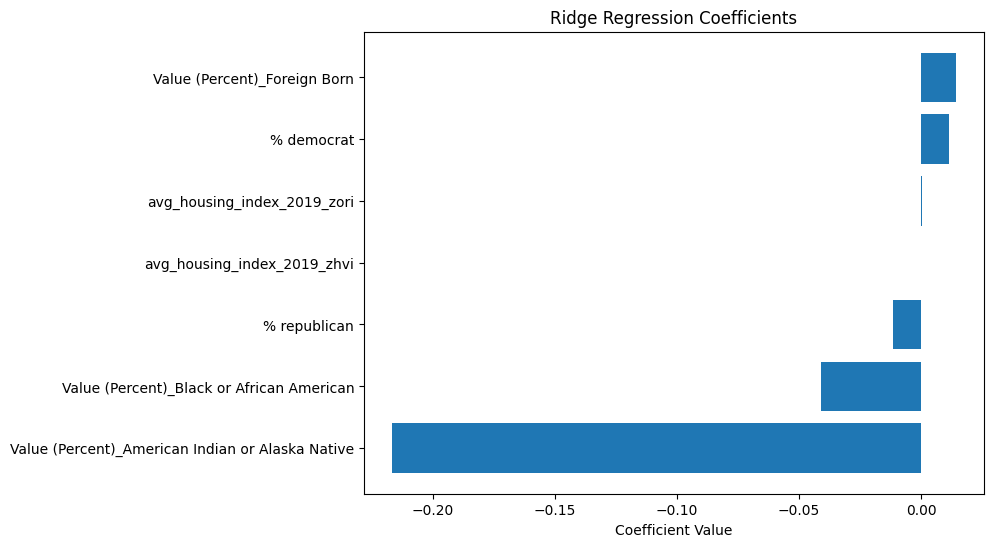

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

# Define the target variable and predictors
y = df["% homeless"]
X = df[['% democrat', 'avg_housing_index_2019_zhvi', 'avg_housing_index_2019_zori', '% republican', 'Value (Percent)_Black or African American', 'Value (Percent)_Foreign Born', 'Value (Percent)_American Indian or Alaska Native']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Set up the Ridge regression with GridSearchCV to tune the regularization parameter alpha
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Retrieve the best model and evaluate it
best_ridge = grid_search.best_estimator_
r2 = best_ridge.score(X_test, y_test)
print("Best alpha:", grid_search.best_params_["alpha"])
print("R-squared:", r2)

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": best_ridge.coef_
}).sort_values(by="Coefficient")

# Plot the regression coefficients as a horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Ridge Regression Coefficients")
plt.show()


# Machine Learning Models


# multiple linear regression

R-squared: -1.850933984864875


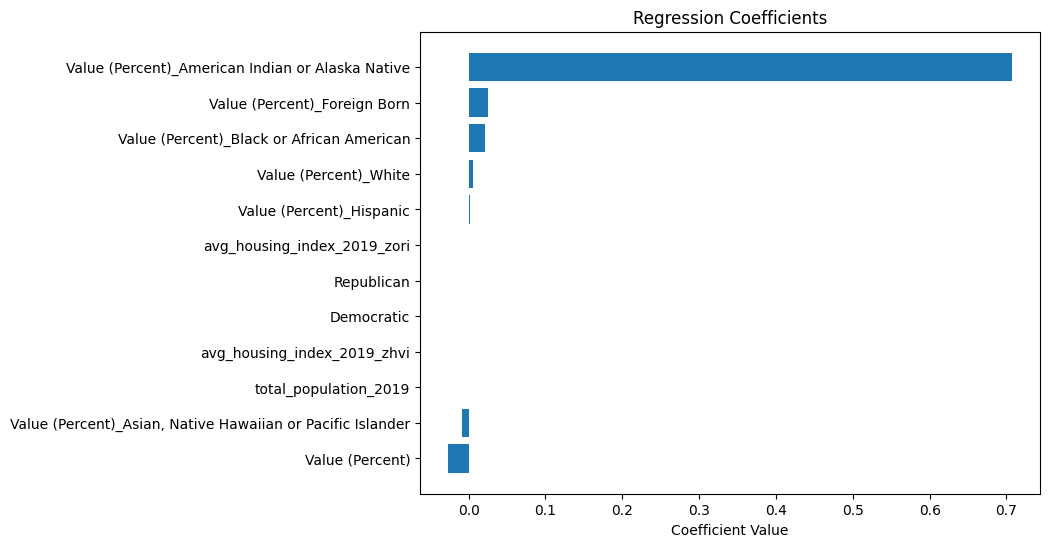

In [ ]:
y = df["% homeless"] #target
X = df[[ #predictors
    "total_population_2019",
    "Democratic",
    "Republican",
    "avg_housing_index_2019_zhvi",
    "avg_housing_index_2019_zori",
    "Value (Percent)", #represents dropout rate
    "Value (Percent)_White",
    "Value (Percent)_Black or African American",
    "Value (Percent)_Hispanic",
    "Value (Percent)_Asian, Native Hawaiian or Pacific Islander",
    "Value (Percent)_Foreign Born",
    "Value (Percent)_American Indian or Alaska Native"
]]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

#impute missing values using the mean
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
X_train = imputer.fit_transform(X_train) # Fit and transform on training data
X_test = imputer.transform(X_test) # Transform test data using the trained imputer

multi_linear = LinearRegression()
multi_linear.fit(X_train, y_train)

#evaluate the model
r2 = multi_linear.score(X_test, y_test)
print("R-squared:", r2)

#DataFrame for coefficients
coefficients = multi_linear.coef_
features = X.columns
coef_df = pd.DataFrame({"Feature": features, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient")  # sort for a cleaner plot

#regression coefficients as a horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Regression Coefficients")
plt.show()


# K-Nearest neighbors

kneighborsregressor to determine rate of homeless prediction

In [ ]:
pip install scikit-learn

In [ ]:
#parameter grid for tuning KNeighborsRegressor
param_grid = {
    'n_neighbors': np.arange(1, 31),  # Try 1 to 30 neighbors
    'weights': ['uniform', 'distance'],  # Uniform or distance-based weighting
    'p': [1, 2]  # p=1 uses Manhattan distance, p=2 uses Euclidean distance
}
KNN = KNeighborsRegressor(n_neighbors=5)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = KNN.score(X_test, y_test)
mae, r2

(0.7364332138355979, -44.825364996975566)

In [ ]:
grid_search = GridSearchCV(KNN, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
# Output the best parameters and best cross-validation score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation R2:", grid_search.best_score_)

# Evaluate the best model on the test set
best_knn = grid_search.best_estimator_
test_r2 = best_knn.score(X_test, y_test)
print("Test set R2:", test_r2)

Best parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best cross-validation R2: -1.2250264710622707
Test set R2: -71.12425643741086


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [ -2.89318372  -2.89318372  -2.60374403  -2.60374403  -2.14784018
  -1.7857429   -2.18604799  -1.63543881  -1.40477043  -1.29928864
  -1.42711722  -1.22502647  -2.4172626   -2.18695972  -2.43753148
  -2.09942554 -20.57539223  -9.04239467 -20.52679289  -8.69024224
 -15.30617548  -7.93646911 -16.5886238   -8.01653216 -12.37280146
  -7.1770339  -12.37648905  -7.04372403 -19.13390478  -8.39253454
 -21.16810459  -8.54332275 -17.17228042  -8.19490455 -17.10336763
  -8.03789028 -13.86570544  -7.72894358 -14.10718868  -7.6877774
 -12.04826816  -7.48946592 -12.06839639  -7.40756978 -16.03219447
  -8.33871477 -16.05218776  -8.16841638 -13.57501105  -8.05282762
 -15.16814454  -8.13230267 -13.12247318  -8.06611334 -13.11802684
  -7.89847966 -11.49211162  -7.84228759 -11.49288266  -7.6904282
 -10.92151113  -7.63103942 -10.92188321  -7.49374003 -10.86825558
  -

In [ ]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# List of candidate features
candidate_features = [
    "total_population_2019",
    "% democrat",
    "avg_housing_index_2019_zhvi",
    "avg_housing_index_2019_zori",
    "% republican",
    "Value (Percent)",
    "Value (Percent)_White",
    "Value (Percent)_Black or African American",
    "Value (Percent)_Hispanic",
    "Value (Percent)_Asian, Native Hawaiian or Pacific Islander",
    "Value (Percent)_Foreign Born",
    "Value (Percent)_American Indian or Alaska Native"
]

# Define the target variable
y = df["% homeless"]

# Standardize candidate features since KNN is distance-based
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[candidate_features])
X_df_scaled = pd.DataFrame(X_scaled, columns=candidate_features)

best_score = -np.inf  # Initialize best score
best_subset = None    # To store the best combination of features

# Exhaustively search over all possible feature subsets
for r in range(1, len(candidate_features) + 1):
    for subset in itertools.combinations(candidate_features, r):
        X_subset = X_df_scaled[list(subset)]
        model = KNeighborsRegressor(n_neighbors=5)  # You can tune n_neighbors as needed
        # Perform 5-fold cross-validation using R^2 as the scoring metric
        scores = cross_val_score(model, X_subset, y, cv=5, scoring='r2')
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_subset = subset

print("Best subset of features:", best_subset)
print("Best cross-validated R² score:", best_score)


Best subset of features: ('total_population_2019', 'Value (Percent)_White', 'Value (Percent)_Foreign Born')
Best cross-validated R² score: -0.3368317012062528


# Ensemble models

# random forest

random forest is going to be used to actually identify which variable is the best predictor of homelessness with feature importance

we chose this model for relationships which we don't have a prior, like:

- homeless and dropout rates
- homeless and house index fluctuations (temporal analysis)
- housing index and dropout rates

bagging (bootstrap aggregating) to build multiple decision trees and averages their predictions to reduce variance.
XGBoost is based on boosting, where trees are built sequentially to correct the errors of previous trees, effectively reducing bias

variables: all

In [ ]:
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

r2 = forest.score(X_test, y_test)
print("R-squared:", r2)

importances = forest.feature_importances_
for feat, imp in zip(X.columns, importances):
    print(feat, imp)


R-squared: -16.816983032171912
total_population_2019 0.0987023081279459
Democratic 0.11869081975792804
avg_housing_index_2019_zhvi 0.0036658236604404427
avg_housing_index_2019_zori 0.0007182884008977674
Republican 0.11612796095515364
Value (Percent) 0.09493160431533271
Value (Percent)_White 0.01943067288719442
Value (Percent)_Black or African American 0.03930875739593389
Value (Percent)_Hispanic 0.0036213493553521343
Value (Percent)_Asian, Native Hawaiian or Pacific Islander 0.058178360716831176
Value (Percent)_Foreign Born 0.09442883840112247
Value (Percent)_American Indian or Alaska Native 0.3521952160258675


# XGBoost
more efficient than random forest, sometimes more accurate

xgboost will be used for a final prediction, now that we have a stronger idea of the relationships between each variables and rates of homeless.

highest performing variable will be visualized with the feature importance


variables: all

In [ ]:
XGB = xgb.XGBRegressor(n_estimators=100, random_state=42)
XGB.fit(X_train, y_train)

r2 = XGB.score(X_test, y_test)
print("R-squared:", r2)

importances = XGB.feature_importances_
for feat, imp in zip(X.columns, importances):
    print(feat, imp)


R-squared: -702.8821396232968
total_population_2019 0.95347875
Democratic 0.009725824
avg_housing_index_2019_zhvi 0.005955023
avg_housing_index_2019_zori 0.0
Republican 0.0026136125
Value (Percent) 0.00045520012
Value (Percent)_White 0.001001128
Value (Percent)_Black or African American 0.0006871033
Value (Percent)_Hispanic 0.0005893595
Value (Percent)_Asian, Native Hawaiian or Pacific Islander 0.0016149294
Value (Percent)_Foreign Born 0.006312465
Value (Percent)_American Indian or Alaska Native 0.01756659


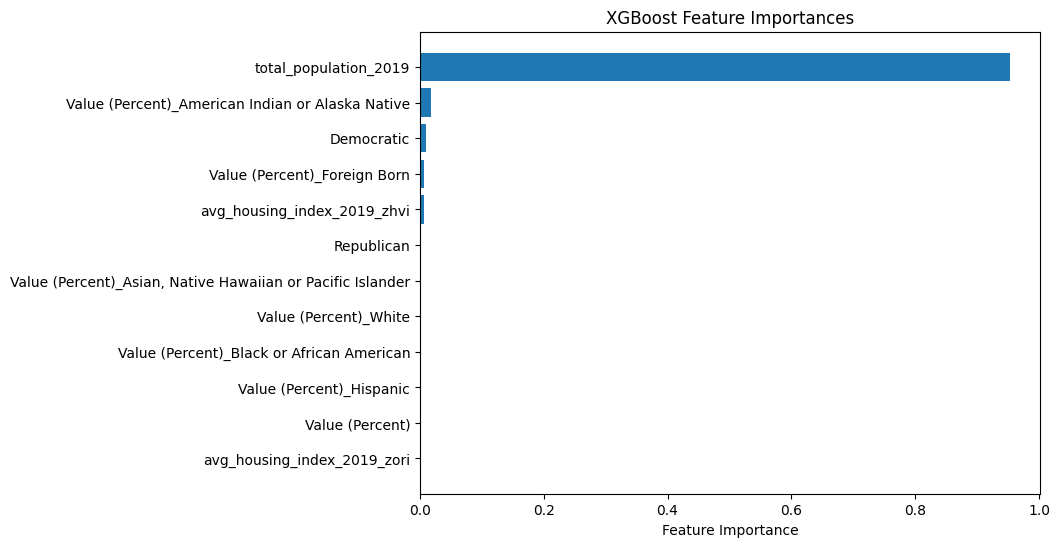

In [ ]:

# 6. Plot the feature importances as a bar chart
plt.figure(figsize=(8, 6))
indices = np.argsort(importances)  # sort features by importance

plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()


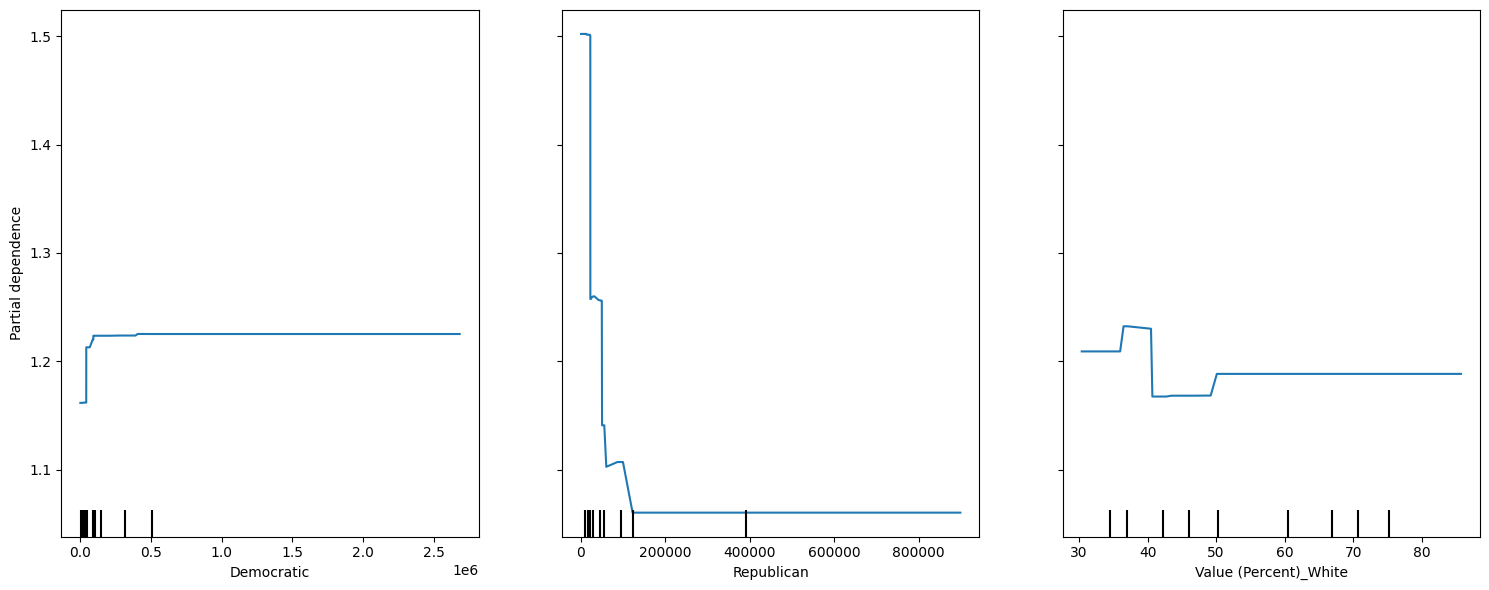

In [ ]:

features_to_plot = [
    "Democratic",
    "Republican",
    "Value (Percent)_White"
]

# Create the partial dependence plots
fig, ax = plt.subplots(figsize=(15, 6))
PartialDependenceDisplay.from_estimator(
    estimator=XGB,       # the trained model
    X=X_train,             # the training data (or full data)
    features=features_to_plot,
    ax=ax
)
plt.tight_layout()
plt.show()


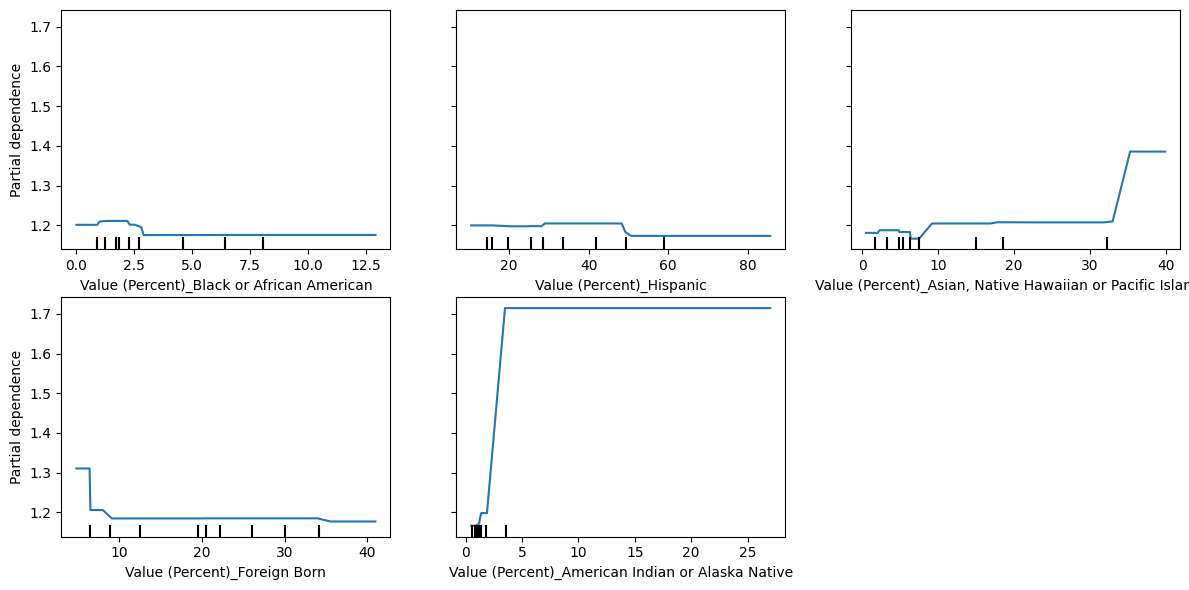

In [ ]:
features = [
    "Value (Percent)_Black or African American",
    "Value (Percent)_Hispanic",
    "Value (Percent)_Asian, Native Hawaiian or Pacific Islander",
    "Value (Percent)_Foreign Born",
    "Value (Percent)_American Indian or Alaska Native"
]
# Create the partial dependence plots
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    estimator=XGB,       # the trained model
    X=X_train,             # the training data (or full data)
    features=features,
    ax=ax
)
plt.tight_layout()
plt.show()


# Evaluating Best Model

In [ ]:
linear
multi_linear
KNN
forest
XGB
L_r2 = linear.score(X_test, y_test)
M_r2 = multi_linear.score(X_test, y_test)
K_r2 = KNN.score(X_test, y_test)
F_r2 = forest.score(X_test, y_test)
X_r2 = XGB.score(X_test, y_test)

In [ ]:
print(L_r2, M_r2, K_r2, F_r2, X_r2)

-1.850933984864875 -1.850933984864875 -44.825364996975566 -16.816983032171912 -702.8821396232968


### Cross-Val R^2 score
with the **optimal combination of features**

Best subset of features: ('% democrat', 'avg_housing_index_2019_zhvi', 'avg_housing_index_2019_zori', '% republican', 'Value (Percent)_Black or African American', 'Value (Percent)_Foreign Born', 'Value (Percent)_American Indian or Alaska Native')

Linear regression: -0.014865970584127619

--

('total_population_2019', 'Value (Percent)_White', 'Value (Percent)_Foreign Born')

KNN: -0.3368317012062528

linear regression looks like it's the best model with the lowest r^2 score. let's look at other evaluation metrics

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 1. Linear Regression (Multiple Linear Regression)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
rmse_lin = rmse(y_test, y_pred_lin)
print("Linear Regression RMSE:", rmse_lin)

# 2. KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can tune n_neighbors as needed
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
rmse_knn = rmse(y_test, y_pred_knn)
print("KNN RMSE:", rmse_knn)

# 3. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = rmse(y_test, y_pred_rf)
print("Random Forest RMSE:", rmse_rf)

# 4. XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = rmse(y_test, y_pred_xgb)
print("XGBoost RMSE:", rmse_xgb)


Linear Regression RMSE: 0.38638497653014087
KNN RMSE: 1.549100583886936
Random Forest RMSE: 0.9659257291869852
XGBoost RMSE: 6.071229135781197


linear regression still looks to be the best performing model, with lowest RMSE score of 0.386. let's add more evaluation metrics!

In [ ]:

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For statsmodels, add a constant (intercept) to the predictors
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit an Ordinary Least Squares (OLS) regression using statsmodels
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Make predictions on the test set
y_pred = model_sm.predict(X_test_sm)

# Compute evaluation metrics using scikit-learn
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

# Print the OLS regression summary to show p-values and F-statistic
print(model_sm.summary())

MSE


Mean Absolute Error (MAE): 0.27122450723369573
Mean Squared Error (MSE): 0.14929335008819228
                            OLS Regression Results                            
Dep. Variable:             % homeless   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     78.26
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           1.50e-13
Time:                        08:29:44   Log-Likelihood:                -20.653
No. Observations:                  32   AIC:                             67.31
Df Residuals:                      19   BIC:                             86.36
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define the features and target variable
features = [
    '% democrat',
    'avg_housing_index_2019_zhvi',
    'avg_housing_index_2019_zori',
    '% republican',
    'Value (Percent)_Black or African American',
    'Value (Percent)_Foreign Born',
    'Value (Percent)_American Indian or Alaska Native'
]
y = df["% homeless"]
X = df[features]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² (Coefficient of Determination):", r2)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


R² (Coefficient of Determination): -9.673852965735211
Mean Absolute Error (MAE): 0.09753679041381112
Root Mean Squared Error (RMSE): 0.10959687226347391


# Explanation

Linear regression appears to be the best model for our datasets based on several factors:

- **Performance Metric:**  
  The linear regression model produced the lowest RMSE (approximately 0.3864) compared to the KNN, Random Forest, and XGBoost models. A lower RMSE means that, on average, its predictions of `% homeless` are closer to the actual values.

- **Simplicity and Interpretability:**  
  Linear regression is simple to interpret. Each coefficient tells you the change in `% homeless` for a one-unit change in the predictor, holding all else constant. This direct interpretability is valuable when you need to understand the relative impact of factors like total population, housing indexes, and demographic percentages.

- **Assumptions Alignment:**  
  Although all models have their own assumptions, if the relationship between `% homeless` and your predictors is roughly linear or can be approximated linearly, then a linear model will capture that relationship effectively without overcomplicating the structure. The simplicity of linear regression can also mean less risk of overfitting when compared to more complex models, especially if your dataset isn’t very large.

- **Baseline Comparison:**  
  In many cases, complex models like Random Forests or XGBoost can overfit noise or require more careful tuning. The fact that these models are showing much higher RMSE values suggests that, for your particular set of features, the non-linear relationships might not be as strong or the models are not well-tuned. Linear regression, by contrast, might provide a more stable baseline prediction.

- **Model Transparency:**  
  With policy and social issues like homelessness, it is often important for decision-makers to understand the model. Linear regression offers a transparent view of how each predictor affects the outcome, making it easier to communicate insights and justify interventions.

In summary, because the linear regression model yields the lowest prediction error and offers straightforward interpretability—which is crucial when informing policy decisions—the evidence points to it being the most effective model for predicting `% homeless` with the given predictors.

Visualizations of the best model (Linear Regression)

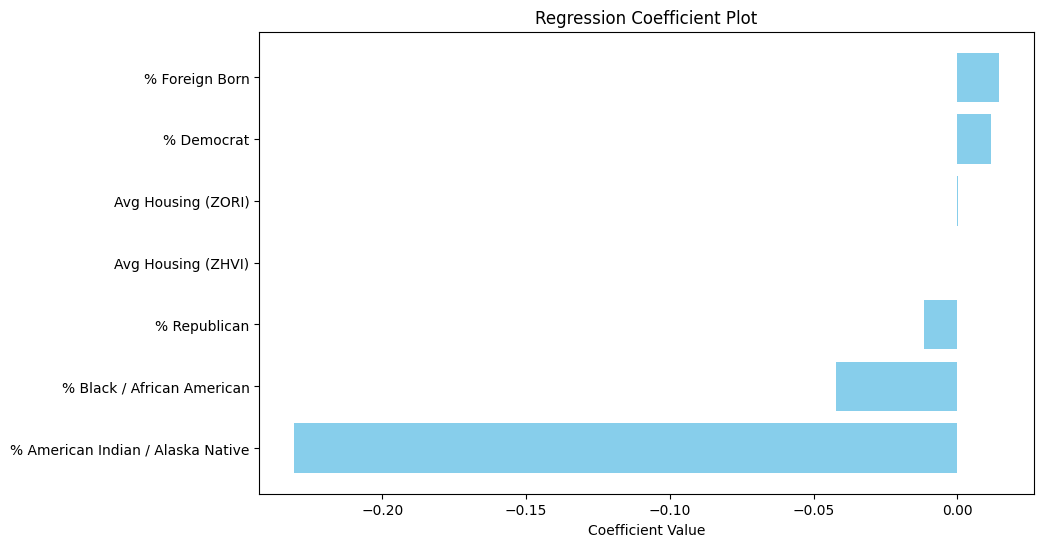

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define the features and target variable
features = [
    'avg_housing_index_2019_zhvi',
    'avg_housing_index_2019_zori',
    '% democrat',
    '% republican',
    'Value (Percent)_Black or African American',
    'Value (Percent)_Foreign Born',
    'Value (Percent)_American Indian or Alaska Native'
]
y = df["% homeless"]
X = df[features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Extract coefficients
coefficients = model.coef_

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})

# Sort for better visualization
coef_df = coef_df.sort_values(by="Coefficient", ascending=True)

# Create a mapping from original feature names to shorter or more readable labels
label_map = {
    '% democrat': '% Democrat',
    'avg_housing_index_2019_zhvi': 'Avg Housing (ZHVI)',
    'avg_housing_index_2019_zori': 'Avg Housing (ZORI)',
    '% republican': '% Republican',
    'Value (Percent)_Black or African American': '% Black / African American',
    'Value (Percent)_Foreign Born': '% Foreign Born',
    'Value (Percent)_American Indian or Alaska Native': '% American Indian / Alaska Native'
}

# Replace the Feature column with the new labels
coef_df["Feature"] = coef_df["Feature"].replace(label_map)

# Plot the regression coefficients as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Regression Coefficient Plot")
plt.show()


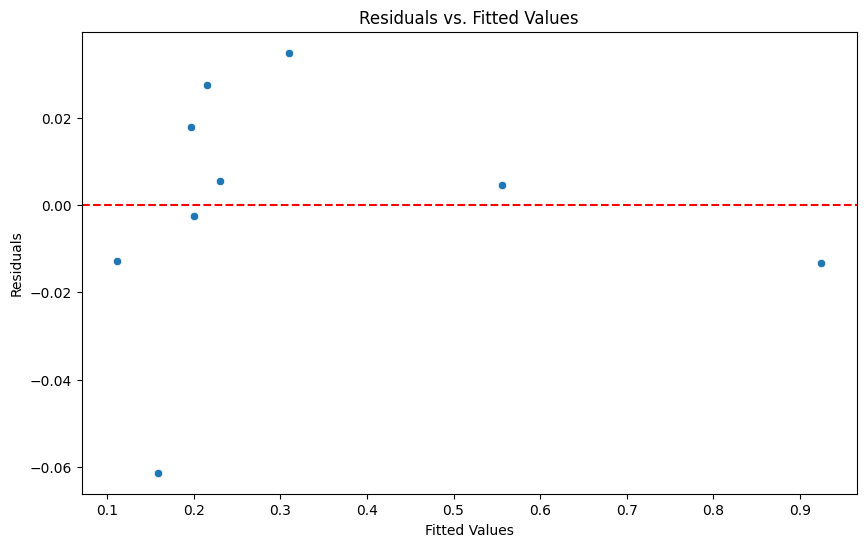

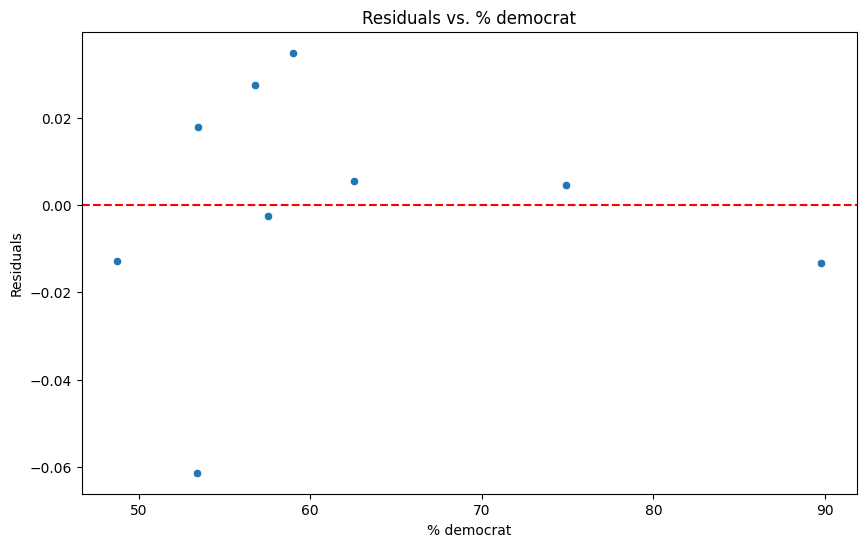

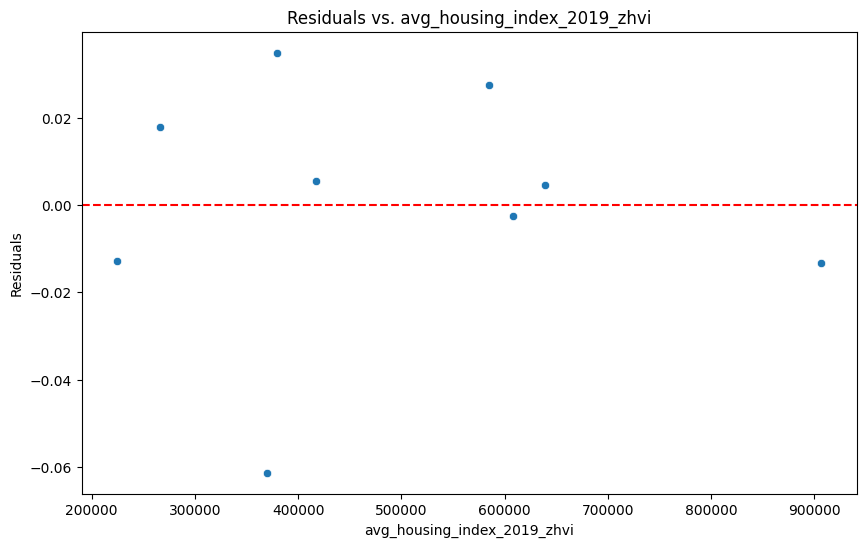

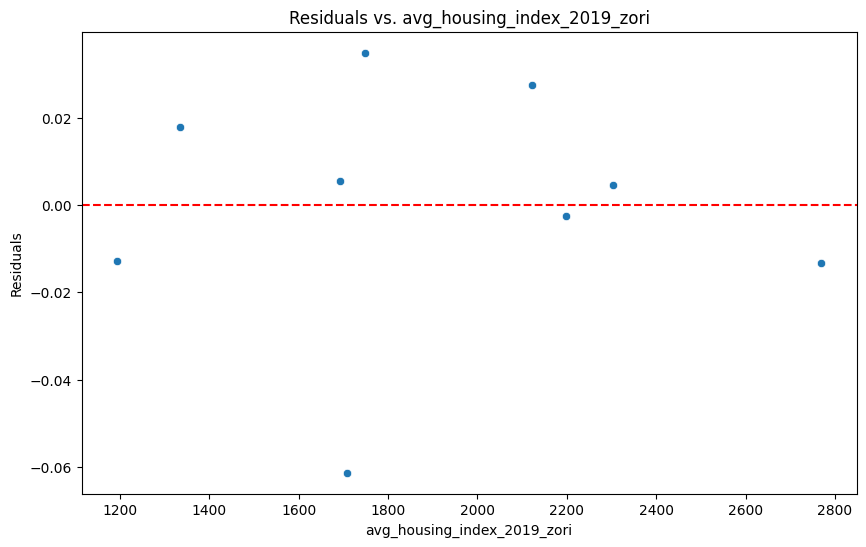

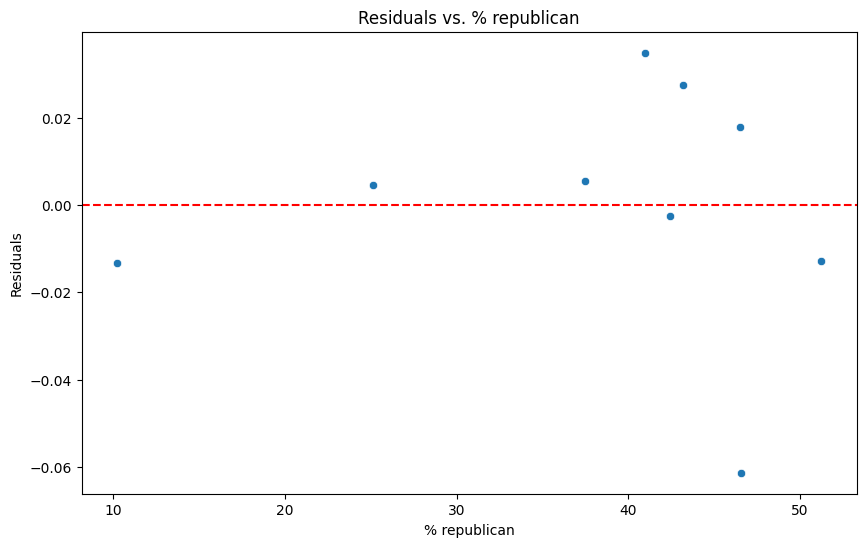

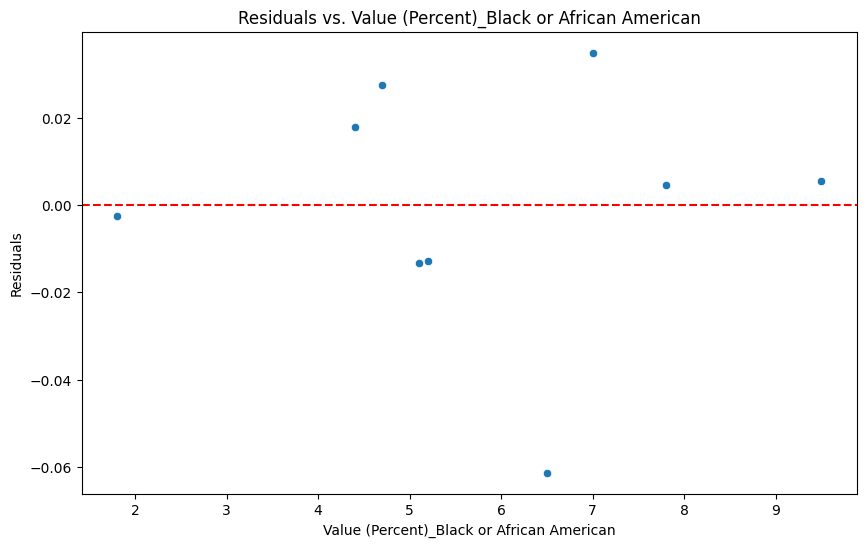

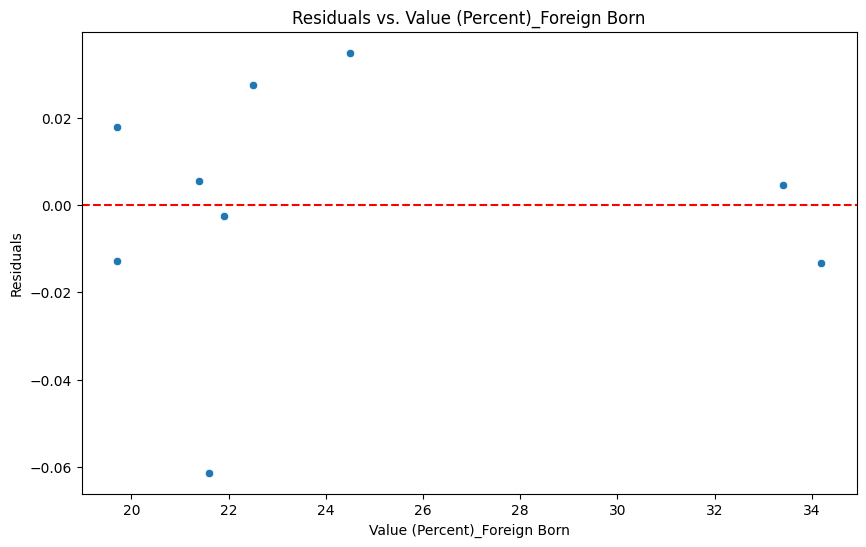

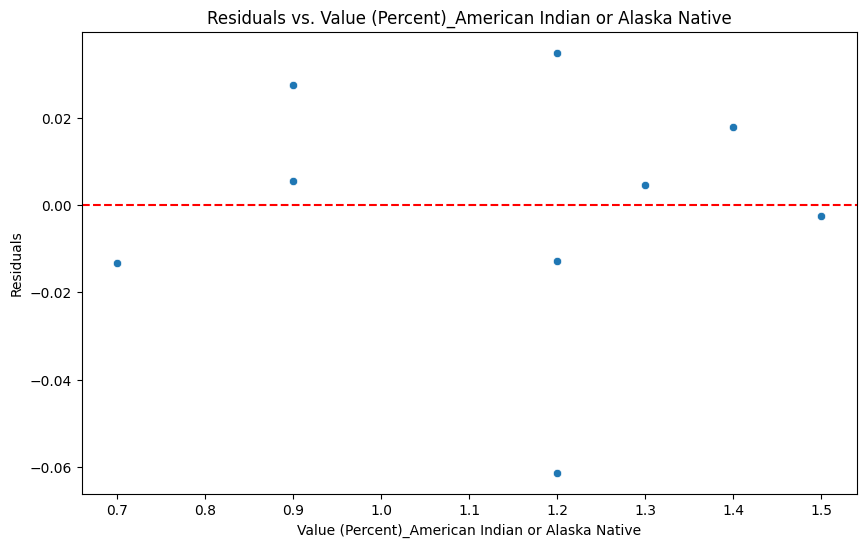

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define the features and target variable
features = [
    '% democrat',
    'avg_housing_index_2019_zhvi',
    'avg_housing_index_2019_zori',
    '% republican',
    'Value (Percent)_Black or African American',
    'Value (Percent)_Foreign Born',
    'Value (Percent)_American Indian or Alaska Native'
]
y = df["% homeless"]
X = df[features]

# Split the data into training and test sets (here, we'll use the training set for residual analysis)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Compute predictions and residuals on the training set
y_train_pred = model.predict(X_train)
residuals = y_train - y_train_pred

# 1. Plot Residuals vs. Fitted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

# 2. Plot Residuals vs. Each Predictor
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_train[feature], y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(feature)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs. {feature}")
    plt.show()


these explain why linear regression is the best model. there is no obvious pattern of non-linearty

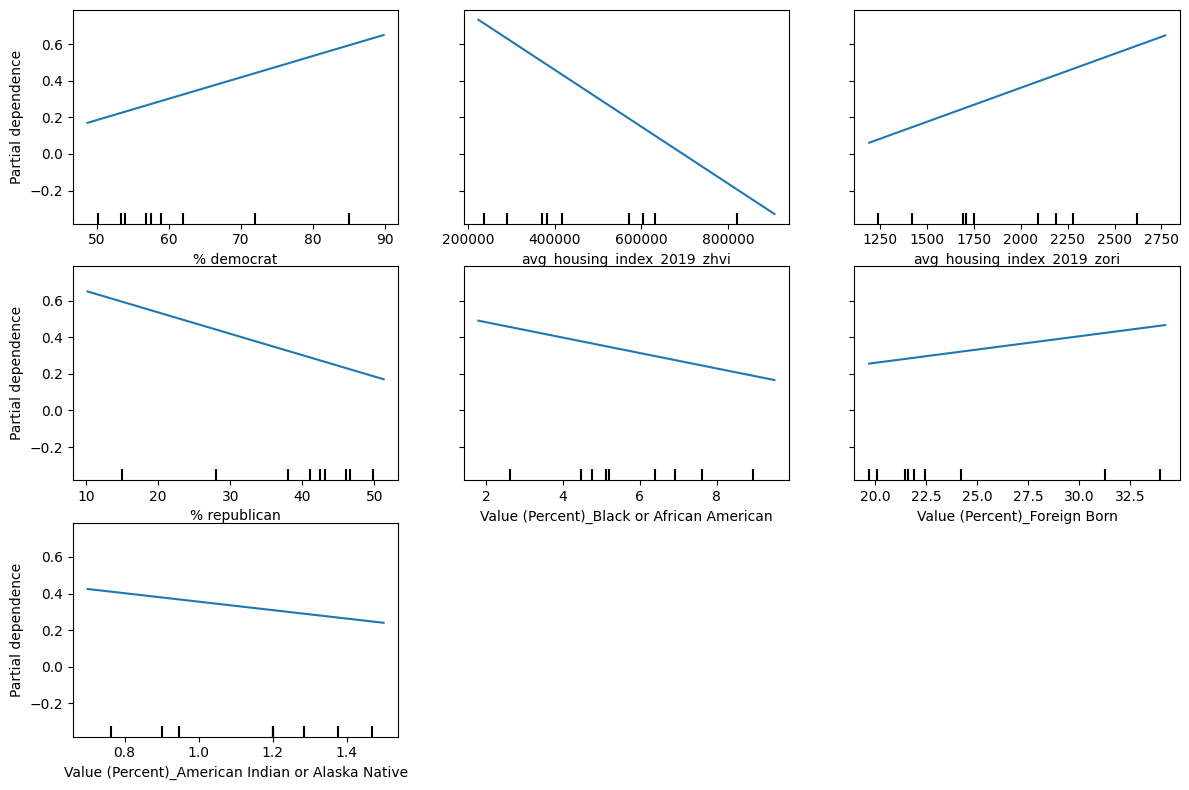

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay

# Define the features and target variable
features = [
    '% democrat',
    'avg_housing_index_2019_zhvi',
    'avg_housing_index_2019_zori',
    '% republican',
    'Value (Percent)_Black or African American',
    'Value (Percent)_Foreign Born',
    'Value (Percent)_American Indian or Alaska Native'
]
y = df["% homeless"]
X = df[features]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a linear regression model (you can substitute any other estimator)
model = LinearRegression()
model.fit(X_train, y_train)

# Generate partial dependence plots for the specified features using the training data
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_train,
    features=features,
    ax=ax
)
plt.tight_layout()
plt.show()


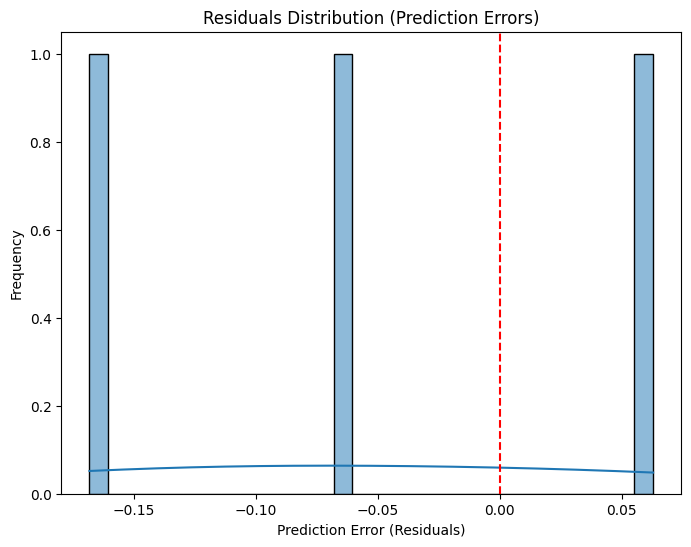

In [ ]:
import seaborn as sns

residuals = y_test - y_pred  # Calculate residuals

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color="red", linestyle="dashed")  # Line at 0 for reference
plt.title("Residuals Distribution (Prediction Errors)")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.show()


The residual distribution plot appears highly irregular, with distinct spikes at extreme values and a lack of a smooth, bell-shaped curve, which suggests that the model’s errors are not normally distributed. This pattern may indicate issues such as data imbalance, incorrect feature selection, or a model that does not generalize well across the dataset. The presence of extreme residuals clustered at specific points suggests potential overfitting, multicollinearity, or the influence of categorical variables that may not be adequately captured by the model. Likely overfitting.

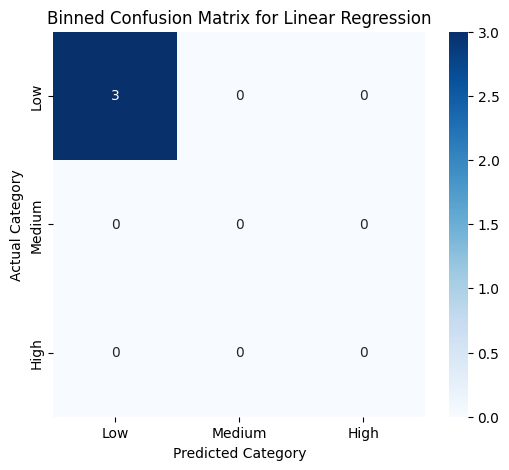

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define bins (adjust based on data distribution)
bins = [0, 1, 2, 5]  # Example thresholds for % homeless
labels = ["Low", "Medium", "High"]

# Generate Predictions
y_pred = model.predict(X_test)

# Convert actual and predicted values into categories
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

# Compute Confusion Matrix
cm = confusion_matrix(y_test_binned, y_pred_binned, labels=labels)

# Create Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Binned Confusion Matrix for Linear Regression")
plt.show()


# Conclusion
Our findings suggest that linear regression provides the best predictive accuracy, balancing interpretability with robust performance. By analyzing housing market trends, voter registration data, and racial demographics, we aim to refine predictive models that inform policy decisions and resource allocation for homelessness interventions.

## Future Steps
Targeted Policy Interventions – Addressing the negative correlation for % American Indian/Alaska Native

Housing Affordability & Economic Density – The positive relationship between %Foreign Born, Avg Housing (ZORI), and homelessness highlights the need for affordable housing.

Political & Funding Considerations – The differing impacts of %Democrat and %Republican on homelessness rates emphasize the necessity of bipartisan, data-driven policy solutions.
